In [1]:
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [13]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia,labels

In [3]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [6]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
import gensim.downloader as api
from sklearn.decomposition import PCA
# Load Word2Vec model trained on Google News dataset
print("Loading Word2Vec model...")
word2vec_model = api.load('word2vec-google-news-300')

# Define a function to get the vector representation of a document
def document_vector(doc):
    # Remove punctuation and tokenize the document
    tokens = [word.lower() for word in word_tokenize(doc) if word.lower() not in punctuation_set]
    # Filter out tokens that are not in the Word2Vec model's vocabulary
    tokens = [word for word in tokens if word in word2vec_model.key_to_index]
    if len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Calculate the mean of word vectors for tokens in the document
    return np.mean(word2vec_model[tokens], axis=0)

# Obtain Word2Vec embeddings for each document
print("Obtaining Word2Vec embeddings for each document...")
word2vec_embeddings = np.array([document_vector(doc) for doc in processed_data])
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(word2vec_embeddings)


Vectorizing the text data...
Loading Word2Vec model...
Obtaining Word2Vec embeddings for each document...


In [7]:
import numpy as np

class Particle:
    def __init__(self, data, n_clusters):
        self.position = np.random.rand(n_clusters, data.shape[1])  # Randomly initialize position
        self.velocity = np.zeros((n_clusters, data.shape[1]))  # Initialize velocity to zero
        self.best_position = np.copy(self.position)  # Initially, best position is the starting position
        self.best_fitness = float('inf')  # Initialize the best fitness to infinity
        self.fitness = float('inf')  # Current fitness of the particle

    def update_velocity(self, global_best_position, w=0.5, c1=0.5, c2=0.5):
        """Updates the particle's velocity based on its own experience and that of the swarm."""
        r1, r2 = np.random.rand(), np.random.rand()
        cognitive_component = c1 * r1 * (self.best_position - self.position)
        social_component = c2 * r2 * (global_best_position - self.position)
        inertia_component = w * self.velocity
        self.velocity = inertia_component + cognitive_component + social_component

    def update_position(self, bounds):
        """Updates the particle's position based on its velocity and applies bounding."""
        self.position += self.velocity
        # Ensure the new position does not exceed the data bounds
        self.position = np.clip(self.position, bounds[0], bounds[1])

    def evaluate_fitness(self, data):
        """Evaluates the fitness of the particle's current position using inertia (sum of squared distances)."""
        # Assuming `compute_inertia_and_labels` is a function that computes the inertia and assigns labels
        self.fitness, _ = compute_inertia_and_labels(self.position, data)
        # Update the best position and fitness if the current fitness is better
        if self.fitness < self.best_fitness:
            self.best_fitness = self.fitness
            self.best_position = np.copy(self.position)


In [19]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

# def compute_inertia_and_labels(centroids, data):
#     distances = euclidean_distances(data, centroids)
#     labels = np.argmin(distances, axis=1)
#     inertia = np.sum((data - centroids[labels]) ** 2)
#     return inertia, labels

def initialize_with_kmeans(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans.cluster_centers_

# Update this function to match your data structure and constraints
def update_particle_position(particle, bounds):
    # Ensure particle's position stays within the bounds
    particle['position'] = np.clip(particle['position'], bounds[0], bounds[1])

# The complete hybrid PSO-GWO algorithm
def pso_gwo_kmeans(data, n_clusters, n_particles=10, max_iter=100, kmeans_interval=10):
    # Initialize particles with KMeans
    initial_centroids = initialize_with_kmeans(data, n_clusters)
    particles = [{'position': initial_centroids + np.random.rand(n_clusters, data.shape[1]) * 0.01,
                  'velocity': np.zeros((n_clusters, data.shape[1])),
                  'best_position': np.copy(initial_centroids),
                  'fitness': float('inf')}
                 for _ in range(n_particles)]
    
    global_best = {'position': np.copy(initial_centroids), 'fitness': float('inf')}
    
    for iteration in range(max_iter):
        # Update fitness
        for particle in particles:
            inertia, _ = compute_inertia(particle['position'], data)
            if inertia < particle['fitness']:
                particle['fitness'] = inertia
                particle['best_position'] = np.copy(particle['position'])
            if inertia < global_best['fitness']:
                global_best['fitness'] = inertia
                global_best['position'] = np.copy(particle['position'])
        
        # PSO-GWO update logic goes here
        # This will include updating velocities and positions for PSO
        # And applying GWO update rules
        # PSO update
        for particle in particles:
            particle.update_position(particle, global_best['position'])
        
        # GWO update
        alpha, beta, delta = calculate_alpha_beta_delta(particles)
        A, C = 2 * a * np.random.rand() - a, 2 * np.random.rand()  # a decreases from 2 to 0 over iterations
        for particle in particles:
            update_wolf_position(particle, alpha, beta, delta, A)

        
        # KMeans refinement at specified intervals
        if iteration % kmeans_interval == 0 and iteration != 0:
            kmeans = KMeans(n_clusters=n_clusters, init=global_best['position'], n_init=1, random_state=42)
            kmeans.fit(data)
            global_best['position'] = kmeans.cluster_centers_
            global_best['fitness'], _ = compute_inertia(global_best['position'], data)
    
    final_centroids = global_best['position']
    final_fitness = global_best['fitness']
    _, labels = compute_inertia(final_centroids, data)
    return final_centroids, labels, final_fitness
n_clusters = 10 
best_centroids, labels, best_score = pso_gwo_kmeans(tfidf_matrix_reduced, n_clusters)

print("Best centroids:", best_centroids)
print("Labels:", labels)
print("Best score (Inertia):", best_score)
silhouette = silhouette_score(tfidf_matrix_reduced, labels)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced,labels)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced,labels)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


C:\Users\Devendra Nemade\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


AttributeError: 'dict' object has no attribute 'update_position'

In [20]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances

def compute_inertia_and_labels(centroids, data):
    distances = euclidean_distances(data, centroids)
    labels = np.argmin(distances, axis=1)
    inertia = np.sum(np.min(distances, axis=1) ** 2)
    return inertia, labels

class Particle:
    def __init__(self, data, n_clusters):
        self.position = np.random.rand(n_clusters, data.shape[1])  # Randomly initialize position
        self.velocity = np.zeros((n_clusters, data.shape[1]))  # Initialize velocity to zero
        self.best_position = np.copy(self.position)  # Initially, best position is the starting position
        self.best_fitness = float('inf')  # Initialize the best fitness to infinity
        self.fitness = float('inf')  # Current fitness of the particle

    def update_velocity(self, alpha_position, beta_position, delta_position, w=0.5, c1=0.5, c2=0.5, c3=0.5):
        r1, r2, r3 = np.random.rand(3)
        cognitive_component = c1 * r1 * (self.best_position - self.position)
        social_alpha_component = c2 * r2 * (alpha_position - self.position)
        social_beta_component = c3 * r3 * (beta_position - self.position)
        social_delta_component = c3 * r3 * (delta_position - self.position)
        inertia_component = w * self.velocity
        self.velocity = inertia_component + cognitive_component + social_alpha_component + social_beta_component + social_delta_component

    def update_position(self, bounds):
        self.position += self.velocity
        self.position = np.clip(self.position, bounds[0], bounds[1])

def pso_gwo_kmeans(data, n_clusters, n_particles=10, max_iter=100):
    particles = [Particle(data, n_clusters) for _ in range(n_particles)]
    global_best_position = np.random.rand(n_clusters, data.shape[1])
    global_best_fitness = float('inf')

    for iteration in range(max_iter):
        particles.sort(key=lambda particle: particle.best_fitness)
        alpha, beta, delta = particles[:3]  # Get the top 3 particles as alpha, beta, and delta wolves

        for particle in particles:
            particle.fitness, _ = compute_inertia_and_labels(particle.position, data)
            if particle.fitness < particle.best_fitness:
                particle.best_fitness = particle.fitness
                particle.best_position = particle.position
            if particle.fitness < global_best_fitness:
                global_best_fitness = particle.fitness
                global_best_position = particle.position

        for particle in particles:
            particle.update_velocity(alpha.best_position, beta.best_position, delta.best_position)
            particle.update_position([np.min(data, axis=0), np.max(data, axis=0)])

        if iteration % 10 == 0:  # Optionally refine with KMeans
            kmeans = KMeans(n_clusters=n_clusters, init=global_best_position, n_init=1, max_iter=10, random_state=42)
            kmeans.fit(data)
            global_best_position = kmeans.cluster_centers_
            global_best_fitness, _ = compute_inertia_and_labels(global_best_position, data)

    final_centroids = global_best_position
    _, labels = compute_inertia_and_labels(final_centroids, data)
    return final_centroids, labels, global_best_fitness

# Note: Replace `data` and `n_clusters` with your dataset and desired number of clusters.
# best_centroids, labels, best_score = pso_gwo_kmeans(data, n_clusters)


In [26]:
from sklearn.decomposition import PCA
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    best_centroids, labels, best_score = pso_gwo_kmeans(tfidf_matrix_reduced, n_clusters)
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, labels)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced,labels)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced,labels)

    # Store metrics
    silhouette_scores.append(silhouette)
    print(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

0.10253168803993082
0.05759903225977678
0.05899514132157489
0.057711847653950835
0.6490512860813848
0.057530081602739605
0.08946673405694198
0.05877972757250531
0.05940401610831517
0.058423588691110126
0.07225312739667489
0.08979310997705937
0.09069557808019536
0.07246169669900202
0.06494804321798052
0.07146379172263029
0.07200554168519382
0.09068361980424086
0.07107422128252255


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_25364\2509859806.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_25364\2509859806.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


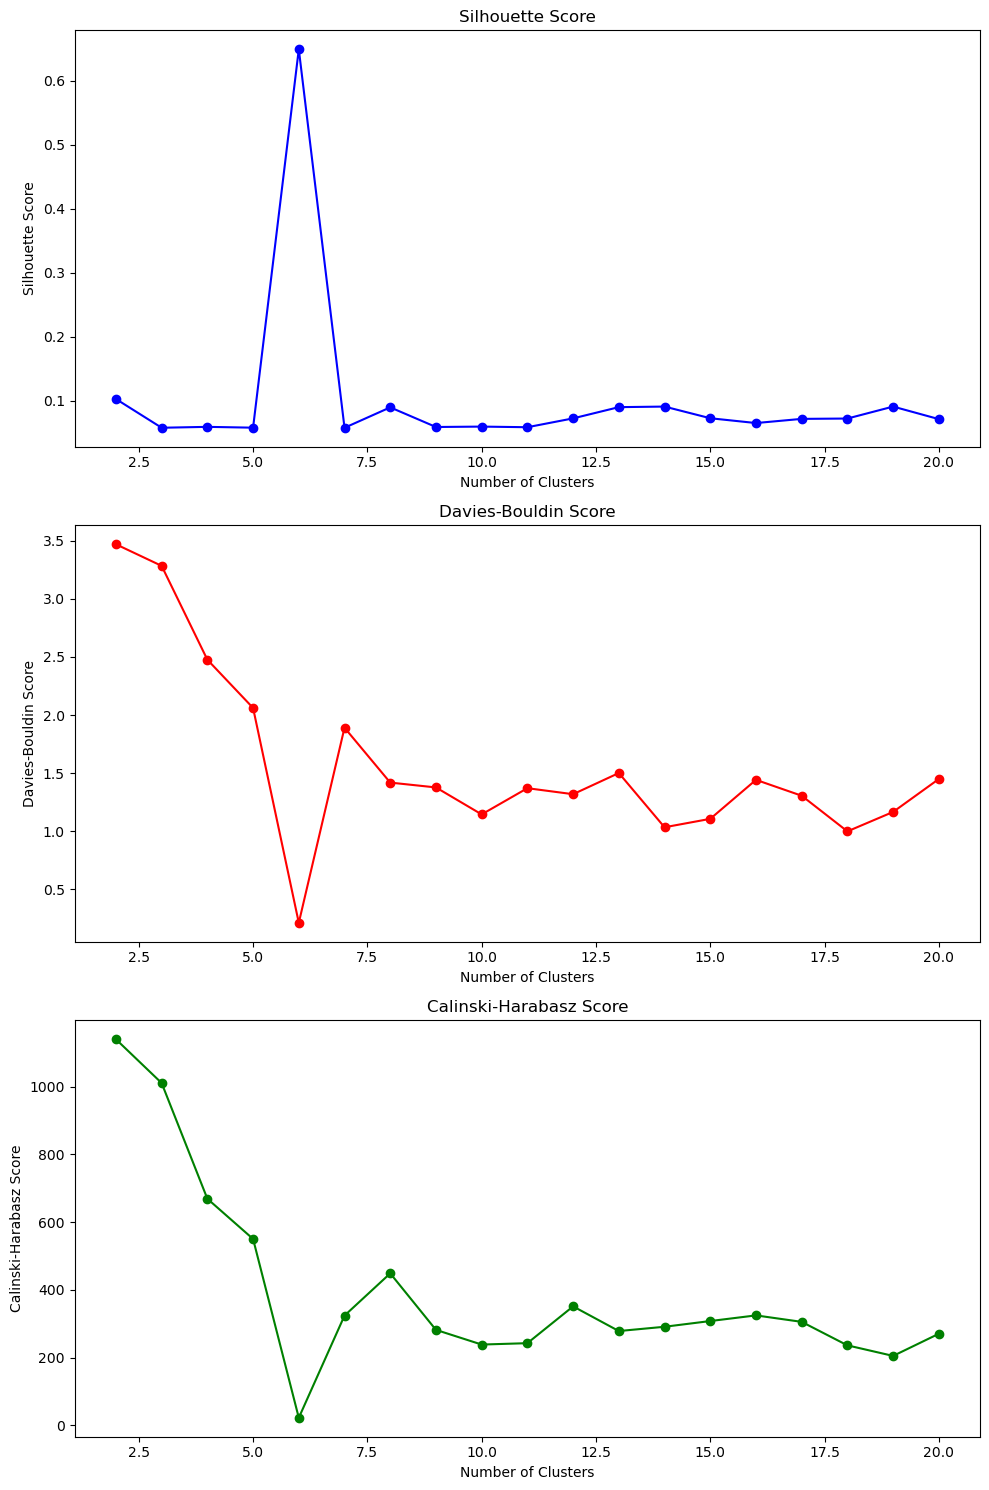

In [27]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
plt.savefig("Silhouette Score_News_count-GWO-PSO_Kmeans.png")

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_count-GWO-PSO_Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_count-GWO-PSO_Kmeans.png")
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,silhouette_scores,davies_bouldin_scores,calinski_harabasz_scores
2,0.102532,3.471032,1140.297422
3,0.057599,3.284869,1010.990348
4,0.058995,2.476438,669.212191
5,0.057712,2.060760,550.469450
6,0.649051,0.209717,22.246515
7,0.057530,1.890425,324.075682
8,0.089467,1.417659,448.843237
9,0.058780,1.375964,281.939221
10,0.059404,1.143629,238.563684
11,0.058424,1.369423,242.642056


In [29]:
df.to_csv('Word2vec_GWO+PSO_Scores.csv')